# XAFS using Larch from Python 3.6

This is an example published originally by [TitanWolf](https://titanwolf.org/Network/Articles/Article?AID=f8639528-1e63-435c-bcd4-e67ed966719a#gsc.tab=0).

Some adaptations were required to run the code are listed as follows.
- Replacing the input file for FeS2.
- using demeter generated file for input to feff6
- generating the FEFF paths using larch feff6. 
- small sintax corrections for python 3.6 

## Libraries

The required libraries are shown below

In [1]:
from larch import Interpreter
import larch_plugins as lp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

session = Interpreter()
%matplotlib inline

## Processing of Data
The following code performs the following tasks
- read the data
- background removal
- EXAFS derivation of extraction and radial structure function of vibration
- plot data

**Note** instead of the Cu file used in the example, we are using the Fe files for the demeter example.

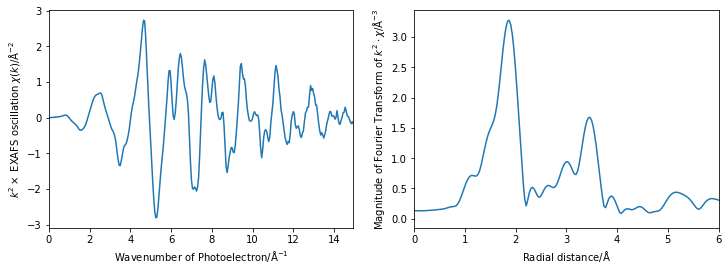

In [2]:
# loading data
Fe_expt = lp.io.read_ascii("fes2_rt01_mar02.xmu", labels="energy mu")#, larch=session)
# calc exafs spectrum
lp.xafs.autobk(Fe_expt, kmin=0.0, kmax=16.5, rbkg=1.0, group=Fe_expt, _larch=session)
# fourier transformation
lp.xafs.xftf(Fe_expt, kweight=2, kmin=3, kmax=15.0, window="hanning", dk=1.0, group=Fe_expt, _larch=session)

# Plot
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax1.plot(Fe_expt.k, Fe_expt.k**2 * Fe_expt.chi)
ax1.set_xlim(0, Fe_expt.k.max())
ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
ax2 = fig.add_subplot(122)
ax2.plot(Fe_expt.r, Fe_expt.chir_mag)
ax2.set_xlim(0, 6)
ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.show()
 

## FEFF input file

 The feff input file fes2_feff.inp was generated from the FeS2.inp file using demeter.
 The generation of feff paths is not presented in the example

In [3]:
# run feff and get the paths
from larch.xafs.feffrunner import feff6l
#feff6l(folder='.', feffinp='feff.inp', verbose=True)
feff6l(folder = './fes2_feff',feffinp='fes2_feff.inp' )

 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neighbor tabl

<External Feff Group: ./fes2_feff\fes2_feff.inp>

## Reading of the scattering path

Load an scattering path calculated in FEFF (using lp.xafs.FeffPathGroup) to read one fo the feffNNNN.dat files. 

In [4]:
fp = lp.xafs.FeffPathGroup(filename='./fes2_feff/feff0001.dat', _larch=session)

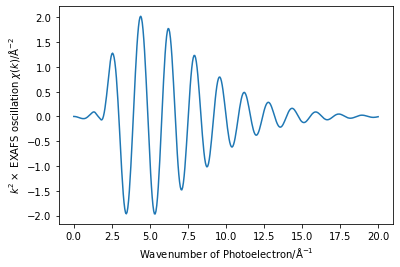

In [5]:
fp._calc_chi(sigma2=0.005)
plt.plot(fp.k, fp.chi*fp.k**2)
plt.xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
plt.ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
plt.show()

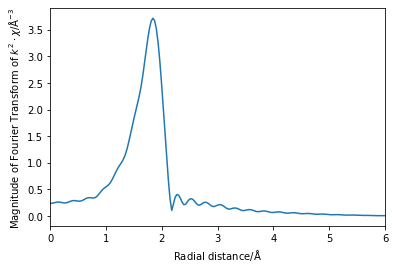

In [6]:
# make Group instance for outputs
from larch.symboltable import Group
fp_group = Group()
# calc EXAFS spectrum
fp._calc_chi(sigma2=0.004)
# fourier transform
lp.xafs.xftf(fp.k, fp.chi, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=fp_group, _larch=session)
# plot
plt.plot(fp_group.r, fp_group.chir_mag)
plt.xlim(0, 6)
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.show()

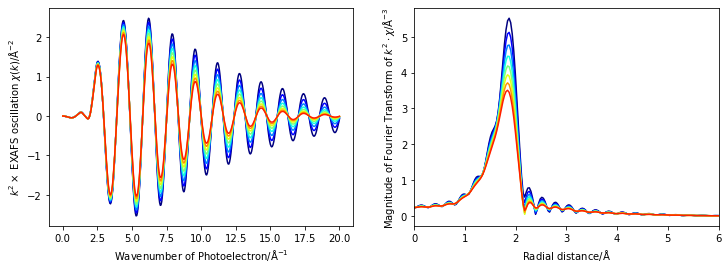

In [7]:
sigma2 = np.arange(0.001, 0.005, 0.0005)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i, s in enumerate(sigma2):
    fp._calc_chi(deltar=0, s02=1, sigma2=s)
    fp_group = Group()
    lp.xafs.xftf(fp.k, fp.chi, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=fp_group, _larch=session)
    ax1.plot(fp.k, fp.chi*fp.k**2, color=cm.jet(float(i) / len(sigma2)))
    ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
    ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
    ax2.plot(fp_group.r, fp_group.chir_mag, color=cm.jet(float(i) / len(sigma2)))
    ax2.set_xlim(0, 6)
    ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
    ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.show()
 

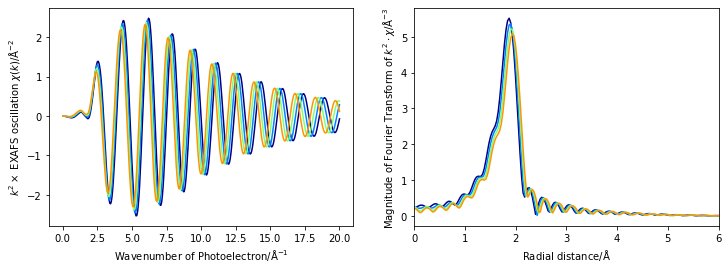

In [8]:
delr = np.arange(0.0, 0.1, 0.025)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i, r in enumerate(delr):
    fp._calc_chi(deltar=r, s02=1, sigma2=0.001)
    fp_group = Group()
    lp.xafs.xftf(fp.k, fp.chi, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=fp_group, _larch=session)
    ax1.plot(fp.k, fp.chi*fp.k**2, color=cm.jet(float(i) / len(delr)))
    ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
    ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
    ax2.plot(fp_group.r, fp_group.chir_mag, color=cm.jet(float(i) / len(delr)))
    ax2.set_xlim(0, 6)
    ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
    ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")

plt.show()

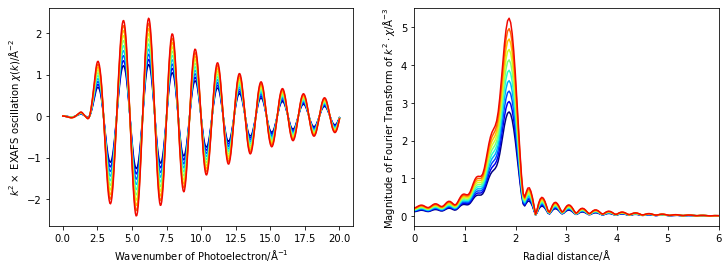

In [9]:
s02 = np.arange(0.5, 1.0, 0.05)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i, s in enumerate(s02):
    fp._calc_chi(deltar=0.0, s02=s, sigma2=0.001)
    fp_group = Group()
    lp.xafs.xftf(fp.k, fp.chi, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=fp_group, _larch=session)
    ax1.plot(fp.k, fp.chi*fp.k**2, color=cm.jet(float(i) / len(s02)))
    ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
    ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
    ax2.plot(fp_group.r, fp_group.chir_mag, color=cm.jet(float(i) / len(s02)))
    ax2.set_xlim(0, 6)
    ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
    ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")

plt.show()
 

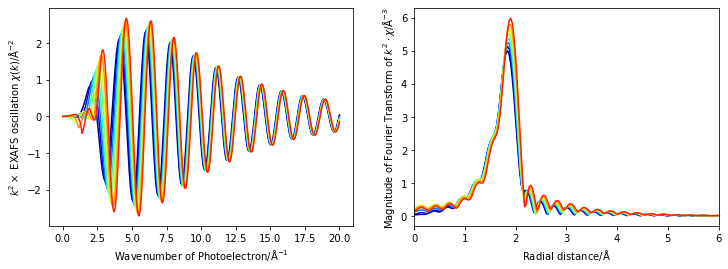

In [10]:
e0 = np.arange(-10.0, 10.0, 2.5)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i, e in enumerate(e0):
    fp._calc_chi(deltar=0.0, s02=1.0, sigma2=0.001, e0=e)
    fp_group = Group()
    lp.xafs.xftf(fp.k, fp.chi, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=fp_group, _larch=session)
    ax1.plot(fp.k, fp.chi*fp.k**2, color=cm.jet(float(i) / len(e0)))
    ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
    ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
    ax2.plot(fp_group.r, fp_group.chir_mag, color=cm.jet(float(i) / len(e0)))
    ax2.set_xlim(0, 6)
    ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
    ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
 
plt.show()

In [11]:
import glob
dat_list = glob.glob('.\\fes2_feff\\feff*.dat')
paths = []

for i, f in enumerate(dat_list):
    i = i + 1
    #print(f)
    num_string = str(i).zfill(4)
    exec('path'+num_string+' = lp.xafs.FeffPathGroup(filename=f, _larch=session)')
    exec('path'+num_string+'._calc_chi(sigma2=0.004)')
    exec('paths.append(path'+num_string+')')
 

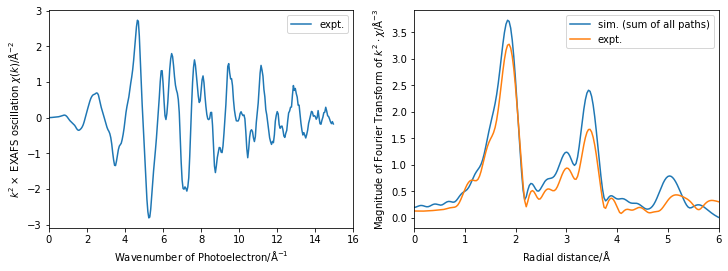

In [14]:
all_path_sum = np.zeros(paths[0].k.shape)
k_calc = paths[0].k
for p in paths:
    all_path_sum += p.chi

all_path_group = Group()

lp.xafs.xftf(k_calc, all_path_sum, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=all_path_group, _larch=session)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#ax1.plot(k_calc+0.1, all_path_sum*Fe_expt.k**2, label='sim. (sum of all paths)')
ax1.plot(Fe_expt.k, Fe_expt.chi*Fe_expt.k**2, label='expt.')
ax1.set_xlim(0, 16)
ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
ax1.legend()
ax2.plot(all_path_group.r, all_path_group.chir_mag, label='sim. (sum of all paths)')
ax2.plot(Fe_expt.r, Fe_expt.chir_mag, label='expt.')
ax2.set_xlim(0, 6)
ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
ax2.legend()
plt.show()
 

In [15]:
path0001.nleg

2

In [16]:
ss_path_sum = np.zeros(paths[0].k.shape)
k_calc = paths[0].k

for p in paths:
    if p.nleg == 2:
        ss_path_sum += p.chi
 

[matplotlib.legend] WARNING : No handles with labels found to put in legend.


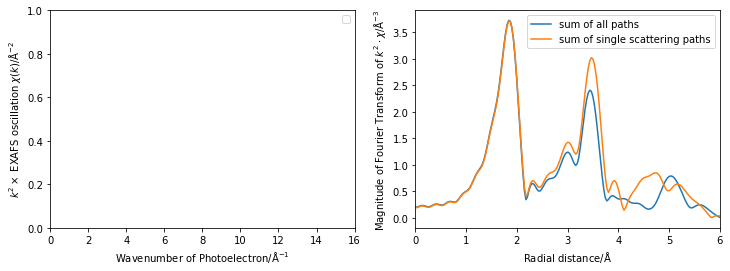

In [17]:
ss_path_group = Group()
lp.xafs.xftf(k_calc, ss_path_sum, kweight=2, kmin=3, kmax=15, dk=1.0, window='hanning', group=ss_path_group, _larch=session)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#ax1.plot(k_calc+0.1, all_path_sum*tmp.k**2, label='sum of all paths')
#ax1.plot(k_calc+0.1, ss_path_sum*tmp.k**2, label='sum of single scattering paths')
ax1.set_xlim(0, 16)
ax1.set_xlabel("Wavenumber of Photoelectron/$\mathrm{\AA}^{-1}$")
ax1.set_ylabel("$k^2 \\times$ EXAFS oscillation $\chi (k)$/$\mathrm{\AA}^{-2}$")
ax1.legend()
ax2.plot(all_path_group.r, all_path_group.chir_mag, label='sum of all paths')
ax2.plot(ss_path_group.r, ss_path_group.chir_mag, label='sum of single scattering paths')
ax2.set_xlim(0, 6)
ax2.set_xlabel("Radial distance/$\mathrm{\AA}$")
ax2.set_ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
ax2.legend(loc='upper right')
plt.show()
 

In [29]:
pars = lp.fitting.param_group(amp    = lp.fitting.param(1.0, vary=True),
                   del_e0 = lp.fitting.param(0.0, vary=True),
                   sig2   = lp.fitting.param(0.0, vary=True),
                   del_r  = lp.fitting.param(0.0, vary=True), _larch=session )

In [31]:
path1 = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0001.dat',
                              s02      = 'amp',
                              e0       = 'del_e0',
                              sigma2   = 'sig2',
                              deltar   = 'del_r',
                              _larch=session)

In [32]:
trans = lp.xafs.TransformGroup(fitspace='r', kmin=3, kmax=14, kw=2, dk=1, window='hanning', rmin=1.4, rmax=3.0, _larch=session)

In [34]:
dset = lp.xafs.FeffitDataSet(data=Fe_expt, pathlist=[path1], transform=trans, _larch=session)

In [35]:
out = lp.xafs.feffit(pars, dset, _larch=session)

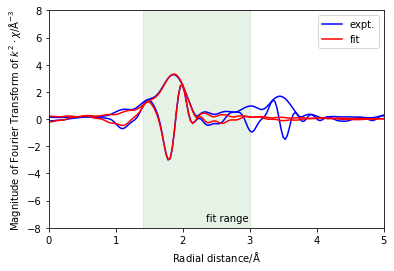

In [36]:
fig = plt.figure()
plt.plot(dset.data.r, dset.data.chir_mag, color='b')
plt.plot(dset.data.r, dset.data.chir_re, color='b', label='expt.')
plt.plot(dset.model.r, dset.model.chir_mag, color='r')
plt.plot(dset.model.r, dset.model.chir_re, color='r', label='fit')
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.xlim(0, 5)
plt.ylim(-8, 8)
plt.fill([1.4, 1.4, 3.0, 3.0],[-8, 8, 8, -8], color='g',alpha=0.1)
plt.text(2.35, -7.5, 'fit range')
plt.legend()
plt.show()

In [38]:
print(lp.xafs.feffit_report(out, _larch=session))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  4, 104
   n_independent      =  12.205
   chi_square         =  7393.16332
   reduced chi_square =  901.109893
   r-factor           =  0.05548661
   Akaike info crit   =  86.1882486
   Bayesian info crit =  88.1954702
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.400, 3.000
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['fes2_feff/feff0001.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=5.2874e-04, std=4.5489e-04)
   epsilon_r          = 0.01093610
   n_independent      = 12.205
 
[[Variables]]
   amp            =  0.75694710 +/- 0.11739146   (init=  1.00000000)
   del_e0         =  4.28965251 +/- 1.84559556   (init=  0.00000000)
   sig2           =  0.00289902 +/- 0.00131603   (init=  0.00000000)
   del_r          =  0.00629140 +/- 0.01131842   (init=  0.00000000)
 
[[Correlations]]    (unreporte